# Redes Adversariales Generativas

Una red adversarial generativa es un mecanismo de DL no supervisado desarrollado en 2014 por el grupo de trabajo de Ian Goodfellow. La red adversarial generativa consiste de dos redes neuronales (generadora y discriminante) que compiten en un juego de engaño. Este tipo de redes aprende a generar nuevos datos usando los features extraídos del conjunto de datos de entrenamiento, estos datos son evaluados por la red discriminante al ser clasificados entre 'real' o 'fake'. El objetivo es generar datos que se parezcan tanto a los reales que el discriminador los clasifique como 'real'.

![](https://miro.medium.com/max/1838/1*5rMmuXmAquGTT-odw-bOpw.jpeg)


En el [artículo principal](https://arxiv.org/pdf/1406.2661.pdf) puede encontrar más referencias a cerca del funcionamiento de las GANs.


## Ejercicio

En este notebook usaremos una de las clases del dataset numérico de MNIST para crear una GAN capaz de producir imágenes sintéticas de esta clase a partir del entrenamiento con imágenes reales del mismo.

In [1]:
#-- Descomprimimos el dataset
# !rm -r mnist
# !unzip /content/drive/MyDrive/Colab/IntroDeepLearning_202102/mnist.zip

In [2]:
#--- Buscamos las direcciones de cada archivo de imagen
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

#--- Ordenamos los datos de forma aleatoria para evitar sesgos
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

import torchvision.transforms as transforms

#--- Transformamos los datos para adaptarlos a la entrada de nuestro discriminador
data_transform = transforms.Compose([
                 transforms.Resize((64, 64)),
                 transforms.Grayscale(3), #Dado que MNIST tiene un solo canal, lo cambiamos a 3 para no tener que modificar más capas en el modelo
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                 ])

#--- Cargamos los datos de entrenamiento en listas
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  target = int(train_file.split('/')[3])
  if target == 8:
    Y_train.append( target )
    X_train.append( np.array(data_transform(Image.open(train_file) )))

#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  test = int(test_file.split('/')[3])
  if target == 8:  
    Y_test.append( target )
    X_test.append( np.array(data_transform(Image.open(test_file)) ))

#--- Convetimos las listas con los datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

#-- Creamos el DataLoader
batch_size = 128


train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [3]:
#-- Creamos una función para visualizar las imágenes en grilla

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_images(images, nmax=64):
    fig = plt.subplots(figsize=(8, 8))
    plt.axis(False)
    plt.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


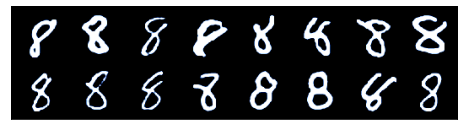

In [4]:
#--- Visualizamos pasando el DataLoader como párametro
show_batch(train_dl,16)

In [5]:
#--- Definimos la GPU como el dispositivo a usar
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
#--- Cargamos los datos a la GPU (Otro método)
new_train_dl = []

for data, label in train_dl:
  data = data.to(device)
  label = label.to(device)
  new_train_dl.append((data,label))

## El Discriminador

El discriminador toma una imagen como entrada. e intenta clasificarla como real o generada. El discriminador toma una imagen de tamaño (3,64,64) y lo convierte a un tensor de tamaño (1, 1 , 1).

In [7]:
#--- Creamos el Discriminador

D = torch.nn.Sequential(
  # in: 3 x 64 x 64
  torch.nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
  torch.nn.BatchNorm2d(64),
  torch.nn.LeakyReLU(0.2),
  # out: 64 x 32 x 32
  
  torch.nn.Dropout(0.3),

  torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
  torch.nn.BatchNorm2d(128),
  torch.nn.LeakyReLU(0.2),
  # out: 128 x 16 x 16

  torch.nn.Dropout(0.3),

  torch.nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
  torch.nn.BatchNorm2d(256),
  torch.nn.LeakyReLU(0.2),
  # out: 256 x 8 x 8

  torch.nn.Dropout(0.3),

  torch.nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
  torch.nn.BatchNorm2d(512),
  torch.nn.LeakyReLU(0.2),
  # out: 512 x 4 x 4

  torch.nn.Dropout(0.3),

  torch.nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
  # out: 1 x 1 x 1

  torch.nn.Flatten(),
  torch.nn.Sigmoid()
)

In [10]:
#-- Cargamos el discriminador en la GPU
D = D.to(device)
d_optmizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

# El generador

La entrada del generador es un vector de números aleatorios que son usados como semilla para la generación de imágenes. El generador puede convertir un tensor de tamaño (latent_size, 1 , 1) a una imagen de tamaño (3,64,64).

In [11]:
#-- Definimos el tamaño latente
latent_size = 128

In [12]:
#--- Definimos el generador
G = torch.nn.Sequential(
  # in: latent_size x 1 x 1
  torch.nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0),
  torch.nn.BatchNorm2d(512),
  torch.nn.ReLU(),
  # out: 512 x 4 x 4

  torch.nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
  torch.nn.BatchNorm2d(256),
  torch.nn.ReLU(),
  # out: 256 x 8 x 8

  torch.nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
  torch.nn.BatchNorm2d(128),
  torch.nn.ReLU(),
  # out: 128 x 16 x 16

  torch.nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
  torch.nn.BatchNorm2d(64),
  torch.nn.ReLU(),
  # out: 64 x 32 x 32

  torch.nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
  torch.nn.Tanh()
  # out: 3 x 64 x 64)
)

# ConvTranspose2d

La operación *ConvTranspose2d* se puede entender como la función opuesta a la Convolución 2d, en este caso se busca generar datos a partir de la información de entrada.

![](https://camo.githubusercontent.com/4c2943c7bf12c841658e2eda9f1f72b698fc8f2b59084ff1330f668b5c4777ff/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e61702d6e6f727468656173742d312e616d617a6f6e6177732e636f6d2f302f3230313339372f34616437323662632d623836662d353366612d366661362d6462336533633866633835312e706e67)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 64, 64])


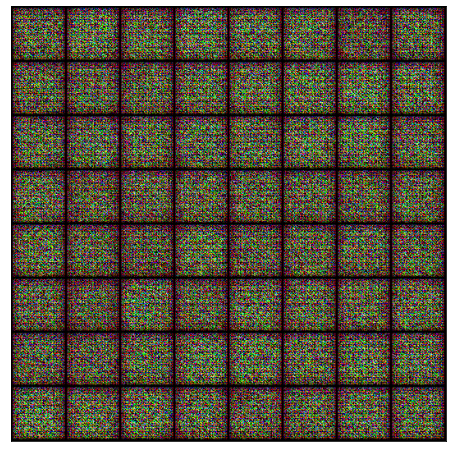

In [14]:
#--- Probamos el generador antes de cargarlo a la GPU
y = torch.randn(batch_size, latent_size, 1, 1) # Tensor con entrada aleatorias
fake_images = G(y)
print(fake_images.shape)
show_images(fake_images)

In [15]:
#--- Cargamos el generador en la GPU
G = G.to(device)
g_optmizer = torch.optim.Adam(generator.parameters(), lr=0.0002)

# Funciones de entrenamiento

Definimos funciones de entrenamiento para el discriminador y el generador. Estas funciones nos permiten entrenar ambos modelos.

In [16]:
#--- Definimos una función para entrenar el discriminador
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()


def train_discriminator(real_images, criterion):
    # Se pasan imágenes reales al discriminador
    real_preds = D(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = criterion(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Se generan imágenes falsas
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = G(latent)

    # Se pasan imágenes falsas al discriminador
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = D(fake_images)
    fake_loss = criterion(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Actualizamos los pesos del discriminador
    reset_grad()
    loss = real_loss + fake_loss
    loss.backward()
    d_optmizer.step()
    return loss.item(), real_score, fake_score

#--- Definimos una función para entrenar el generador
def train_generator(criterion):
    
    # Generamos imágenes falsas
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Tratamos de engañar al discriminador
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = criterion(preds, targets)
    
    # Actualizamos los pesos del generador
    reset_grad()
    loss.backward()
    g_optmizer.step()
    
    return loss.item()

In [17]:
#--- Creamos una función que nos permita visualizar los resultados parciales
def visualize_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors.to(device))
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.to('cpu').detach(), nrow=8).permute(1, 2, 0))
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


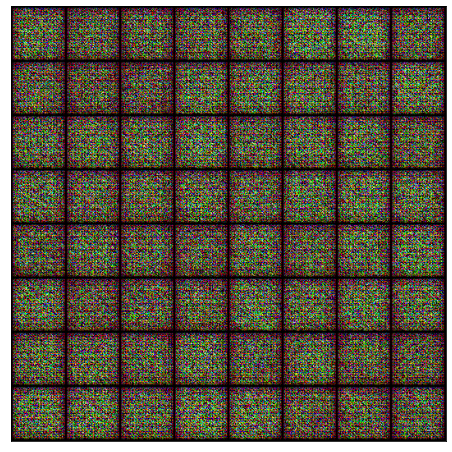

In [18]:
#--- Probamos nuestra función de evaluación del modelo con una entrada aleatoria
fixed_latent = torch.randn(64, latent_size, 1, 1 , device=torch.device('cuda'))
visualize_samples(0, fixed_latent)

# Entrenamiento de la GAN

Creamos una función que nos permita entrenar simultaneamente el discriminador y el generador.

In [19]:
#--- Finalmente definimos una función para entrenar nuestra GAN
from tqdm.notebook import tqdm

history = hl.History()
canvas = hl.Canvas()

def fit(n_epoch):
    torch.cuda.empty_cache()

    # Losses y Scores
    d_losses, g_losses, accs_real, accs_fake = [], [], [], []

    criterion = torch.nn.BCELoss()

    iter = 0
    # Ciclo de entranmiento
    pbar = tqdm(total=n_epoch)

    for epoch in range(n_epoch):
        for real_images, _ in new_train_dl:
            # Entrenamos el discriminador
            d_loss, acc_real, acc_fake = train_discriminator(real_images, criterion)

            # Entrenamos el generador
            g_loss = train_generator(criterion)
            
        # Guardamos losses y scores
        g_losses.append(g_loss)
        d_losses.append(d_loss)
        accs_real.append(acc_real)
        accs_fake.append(acc_fake)
        
        # Imprimimos losses y scores del último batch
        print("Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, acc_real: {:.4f}, acc_fake: {:.4f}".format(
            epoch+1, n_epoch, d_loss, g_loss, acc_real, acc_fake))
    
        # Graficamos los resultados parciales del modelo cada 10 épocas
        iter += 1
        if epoch%10 == 9:
          visualize_samples(epoch+1, fixed_latent, show=True)
        
        pbar.update(1)
    pbar.close()

    return g_losses, d_losses, accs_real, accs_fake

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [1/300], loss_g: 3.9582, loss_d: 0.2040, acc_real: 0.8991, acc_fake: 0.0809
Epoch [2/300], loss_g: 4.7170, loss_d: 0.1353, acc_real: 0.9513, acc_fake: 0.0703
Epoch [3/300], loss_g: 5.4113, loss_d: 0.1129, acc_real: 0.9467, acc_fake: 0.0300
Epoch [4/300], loss_g: 6.6157, loss_d: 0.0543, acc_real: 0.9710, acc_fake: 0.0200
Epoch [5/300], loss_g: 5.9241, loss_d: 0.0457, acc_real: 0.9828, acc_fake: 0.0239
Epoch [6/300], loss_g: 7.2384, loss_d: 0.0243, acc_real: 0.9866, acc_fake: 0.0065
Epoch [7/300], loss_g: 6.5734, loss_d: 0.0225, acc_real: 0.9942, acc_fake: 0.0162
Epoch [8/300], loss_g: 8.2396, loss_d: 0.0076, acc_real: 0.9958, acc_fake: 0.0033
Epoch [9/300], loss_g: 7.3563, loss_d: 0.0138, acc_real: 0.9955, acc_fake: 0.0090


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [10/300], loss_g: 7.6559, loss_d: 0.0084, acc_real: 0.9981, acc_fake: 0.0064


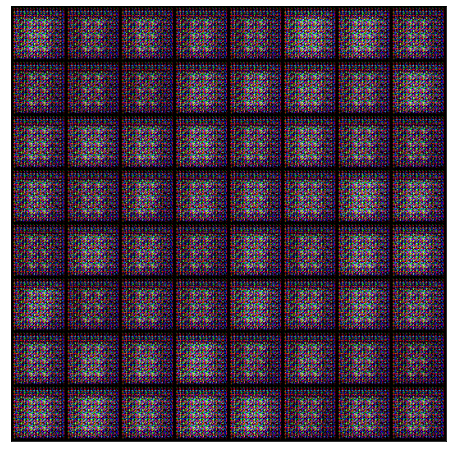

Epoch [11/300], loss_g: 8.0469, loss_d: 0.0089, acc_real: 0.9963, acc_fake: 0.0051
Epoch [12/300], loss_g: 7.5653, loss_d: 0.0094, acc_real: 0.9961, acc_fake: 0.0054
Epoch [13/300], loss_g: 7.5689, loss_d: 0.0070, acc_real: 0.9982, acc_fake: 0.0051
Epoch [14/300], loss_g: 8.0032, loss_d: 0.0026, acc_real: 0.9990, acc_fake: 0.0016
Epoch [15/300], loss_g: 7.4467, loss_d: 0.0035, acc_real: 0.9992, acc_fake: 0.0027
Epoch [16/300], loss_g: 7.6159, loss_d: 0.0056, acc_real: 0.9986, acc_fake: 0.0042
Epoch [17/300], loss_g: 7.9230, loss_d: 0.0068, acc_real: 0.9982, acc_fake: 0.0049
Epoch [18/300], loss_g: 8.5192, loss_d: 0.0044, acc_real: 0.9976, acc_fake: 0.0019
Epoch [19/300], loss_g: 8.2364, loss_d: 0.0039, acc_real: 0.9982, acc_fake: 0.0021


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [20/300], loss_g: 8.1032, loss_d: 0.0028, acc_real: 0.9994, acc_fake: 0.0022


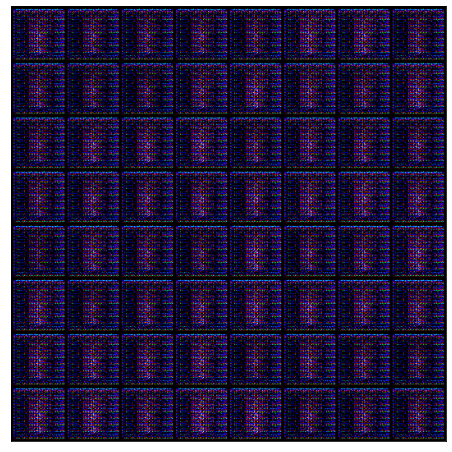

Epoch [21/300], loss_g: 8.3573, loss_d: 0.0034, acc_real: 0.9989, acc_fake: 0.0023
Epoch [22/300], loss_g: 8.7792, loss_d: 0.0035, acc_real: 0.9981, acc_fake: 0.0016
Epoch [23/300], loss_g: 8.7592, loss_d: 0.0075, acc_real: 0.9969, acc_fake: 0.0042
Epoch [24/300], loss_g: 9.2597, loss_d: 0.0036, acc_real: 0.9980, acc_fake: 0.0015
Epoch [25/300], loss_g: 9.3670, loss_d: 0.0031, acc_real: 0.9992, acc_fake: 0.0024
Epoch [26/300], loss_g: 9.9917, loss_d: 0.0017, acc_real: 0.9989, acc_fake: 0.0005
Epoch [27/300], loss_g: 9.0240, loss_d: 0.0046, acc_real: 0.9992, acc_fake: 0.0037
Epoch [28/300], loss_g: 9.3275, loss_d: 0.0073, acc_real: 0.9967, acc_fake: 0.0039
Epoch [29/300], loss_g: 10.6605, loss_d: 0.0058, acc_real: 0.9952, acc_fake: 0.0009


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [30/300], loss_g: 11.4862, loss_d: 0.0024, acc_real: 0.9990, acc_fake: 0.0014


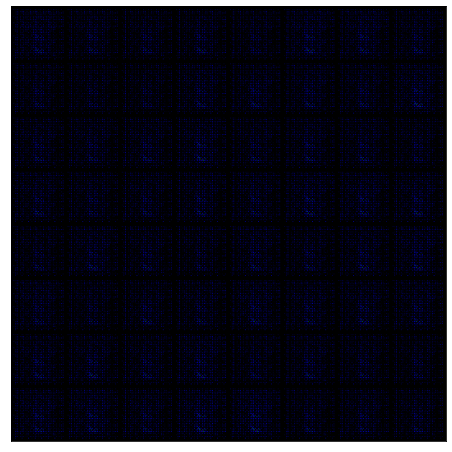

Epoch [31/300], loss_g: 11.4207, loss_d: 0.0088, acc_real: 0.9931, acc_fake: 0.0014
Epoch [32/300], loss_g: 14.5448, loss_d: 0.0085, acc_real: 0.9924, acc_fake: 0.0002
Epoch [33/300], loss_g: 12.8493, loss_d: 0.0022, acc_real: 0.9996, acc_fake: 0.0018
Epoch [34/300], loss_g: 14.5620, loss_d: 0.0006, acc_real: 0.9994, acc_fake: 0.0000
Epoch [35/300], loss_g: 13.0755, loss_d: 0.0024, acc_real: 0.9999, acc_fake: 0.0021
Epoch [36/300], loss_g: 14.6856, loss_d: 0.0006, acc_real: 0.9994, acc_fake: 0.0000
Epoch [37/300], loss_g: 11.5203, loss_d: 0.0002, acc_real: 0.9999, acc_fake: 0.0001
Epoch [38/300], loss_g: 11.4457, loss_d: 0.0004, acc_real: 0.9999, acc_fake: 0.0003
Epoch [39/300], loss_g: 11.1596, loss_d: 0.0020, acc_real: 0.9983, acc_fake: 0.0001


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [40/300], loss_g: 9.7485, loss_d: 0.0009, acc_real: 0.9998, acc_fake: 0.0007


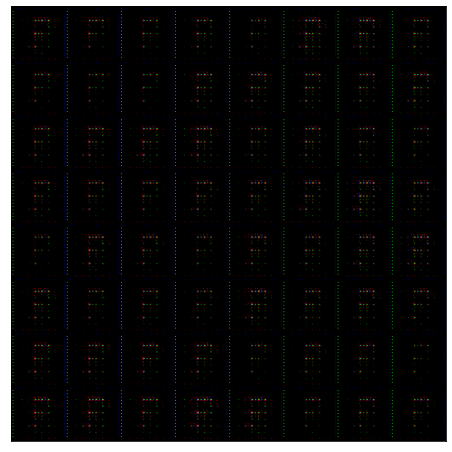

Epoch [41/300], loss_g: 10.9762, loss_d: 0.0007, acc_real: 0.9994, acc_fake: 0.0001
Epoch [42/300], loss_g: 9.9384, loss_d: 0.0005, acc_real: 0.9998, acc_fake: 0.0003
Epoch [43/300], loss_g: 9.6262, loss_d: 0.0005, acc_real: 0.9999, acc_fake: 0.0004
Epoch [44/300], loss_g: 9.9563, loss_d: 0.0004, acc_real: 0.9999, acc_fake: 0.0003
Epoch [45/300], loss_g: 9.9459, loss_d: 0.0004, acc_real: 0.9999, acc_fake: 0.0003
Epoch [46/300], loss_g: 9.5175, loss_d: 0.0005, acc_real: 0.9999, acc_fake: 0.0004
Epoch [47/300], loss_g: 9.5807, loss_d: 0.0006, acc_real: 0.9997, acc_fake: 0.0003
Epoch [48/300], loss_g: 9.5381, loss_d: 0.0004, acc_real: 0.9999, acc_fake: 0.0003
Epoch [49/300], loss_g: 9.4761, loss_d: 0.0005, acc_real: 0.9998, acc_fake: 0.0003


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [50/300], loss_g: 9.4008, loss_d: 0.0004, acc_real: 0.9999, acc_fake: 0.0004


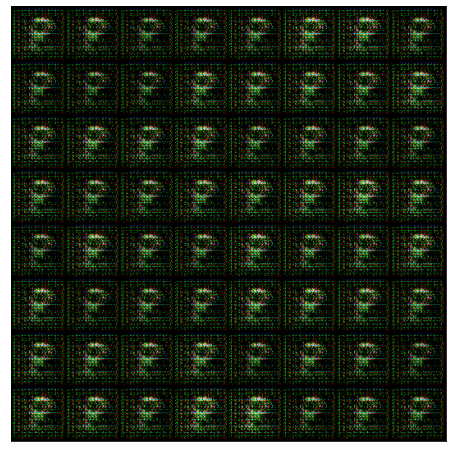

Epoch [51/300], loss_g: 9.8058, loss_d: 0.0005, acc_real: 0.9999, acc_fake: 0.0003
Epoch [52/300], loss_g: 9.6810, loss_d: 0.0005, acc_real: 0.9999, acc_fake: 0.0005
Epoch [53/300], loss_g: 9.5487, loss_d: 0.0006, acc_real: 0.9998, acc_fake: 0.0005
Epoch [54/300], loss_g: 9.8824, loss_d: 0.0006, acc_real: 0.9998, acc_fake: 0.0003
Epoch [55/300], loss_g: 9.7026, loss_d: 0.0005, acc_real: 0.9999, acc_fake: 0.0003
Epoch [56/300], loss_g: 9.6249, loss_d: 0.0004, acc_real: 0.9999, acc_fake: 0.0003
Epoch [57/300], loss_g: 9.1940, loss_d: 0.0007, acc_real: 0.9999, acc_fake: 0.0006
Epoch [58/300], loss_g: 9.7872, loss_d: 0.0004, acc_real: 0.9999, acc_fake: 0.0002
Epoch [59/300], loss_g: 9.5245, loss_d: 0.0005, acc_real: 0.9997, acc_fake: 0.0002


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [60/300], loss_g: 9.4951, loss_d: 0.0006, acc_real: 0.9998, acc_fake: 0.0004


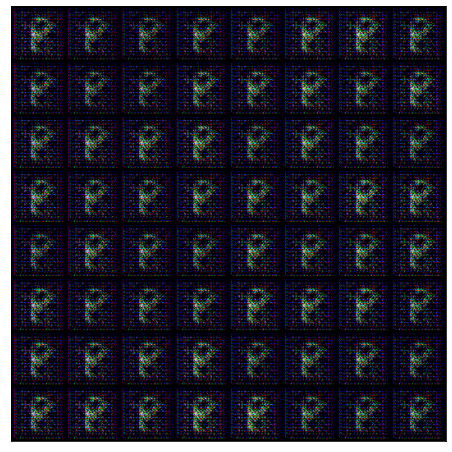

Epoch [61/300], loss_g: 9.6354, loss_d: 0.0006, acc_real: 0.9997, acc_fake: 0.0003
Epoch [62/300], loss_g: 9.8863, loss_d: 0.0006, acc_real: 0.9997, acc_fake: 0.0003
Epoch [63/300], loss_g: 10.0923, loss_d: 0.0004, acc_real: 0.9998, acc_fake: 0.0002
Epoch [64/300], loss_g: 10.3709, loss_d: 0.0003, acc_real: 0.9998, acc_fake: 0.0002
Epoch [65/300], loss_g: 10.9139, loss_d: 0.0005, acc_real: 0.9996, acc_fake: 0.0001
Epoch [66/300], loss_g: 11.0213, loss_d: 0.0003, acc_real: 0.9999, acc_fake: 0.0002
Epoch [67/300], loss_g: 10.6933, loss_d: 0.0003, acc_real: 0.9999, acc_fake: 0.0002
Epoch [68/300], loss_g: 10.6101, loss_d: 0.0004, acc_real: 0.9999, acc_fake: 0.0002
Epoch [69/300], loss_g: 10.5378, loss_d: 0.0005, acc_real: 0.9998, acc_fake: 0.0003


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [70/300], loss_g: 9.6658, loss_d: 0.0021, acc_real: 0.9984, acc_fake: 0.0004


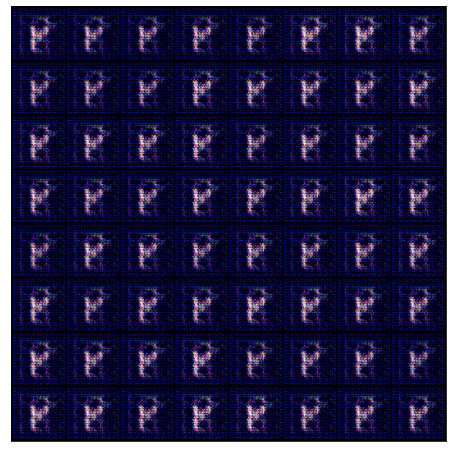

Epoch [71/300], loss_g: 10.2036, loss_d: 0.0006, acc_real: 0.9999, acc_fake: 0.0005
Epoch [72/300], loss_g: 11.2749, loss_d: 0.0002, acc_real: 0.9999, acc_fake: 0.0001
Epoch [73/300], loss_g: 10.3783, loss_d: 0.0003, acc_real: 0.9999, acc_fake: 0.0002
Epoch [74/300], loss_g: 10.3794, loss_d: 0.0007, acc_real: 0.9997, acc_fake: 0.0004
Epoch [75/300], loss_g: 10.8065, loss_d: 0.0016, acc_real: 0.9991, acc_fake: 0.0007
Epoch [76/300], loss_g: 15.8373, loss_d: 0.0069, acc_real: 0.9999, acc_fake: 0.0065
Epoch [77/300], loss_g: 13.9101, loss_d: 0.0115, acc_real: 1.0000, acc_fake: 0.0103
Epoch [78/300], loss_g: 8.6306, loss_d: 0.0010, acc_real: 1.0000, acc_fake: 0.0009
Epoch [79/300], loss_g: 24.3171, loss_d: 0.0009, acc_real: 0.9991, acc_fake: 0.0000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [80/300], loss_g: 1.9768, loss_d: 0.0507, acc_real: 1.0000, acc_fake: 0.0478


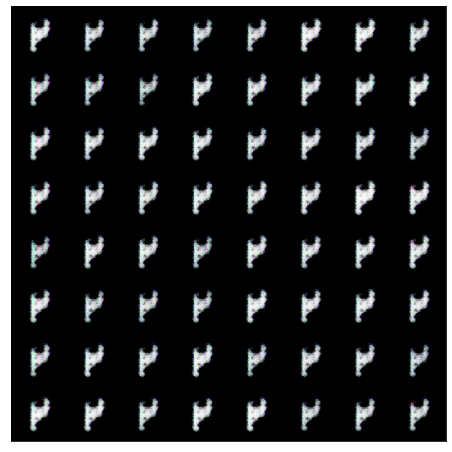

Epoch [81/300], loss_g: 11.7022, loss_d: 0.0240, acc_real: 0.9833, acc_fake: 0.0002
Epoch [82/300], loss_g: 3.6771, loss_d: 0.3210, acc_real: 0.8829, acc_fake: 0.0372
Epoch [83/300], loss_g: 4.8227, loss_d: 0.7679, acc_real: 0.7194, acc_fake: 0.0411
Epoch [84/300], loss_g: 8.6897, loss_d: 0.1467, acc_real: 0.9068, acc_fake: 0.0067
Epoch [85/300], loss_g: 7.4016, loss_d: 0.1463, acc_real: 0.9831, acc_fake: 0.1009
Epoch [86/300], loss_g: 8.5204, loss_d: 0.0656, acc_real: 0.9573, acc_fake: 0.0014
Epoch [87/300], loss_g: 6.0327, loss_d: 0.0420, acc_real: 0.9980, acc_fake: 0.0373
Epoch [88/300], loss_g: 8.8488, loss_d: 0.0140, acc_real: 0.9892, acc_fake: 0.0024
Epoch [89/300], loss_g: 6.7849, loss_d: 0.0160, acc_real: 0.9915, acc_fake: 0.0070


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [90/300], loss_g: 7.3325, loss_d: 0.0426, acc_real: 0.9850, acc_fake: 0.0249


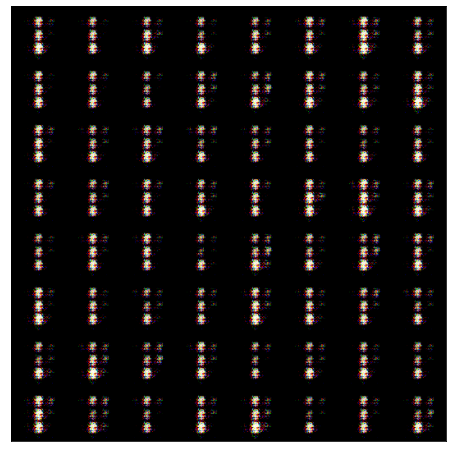

Epoch [91/300], loss_g: 6.2929, loss_d: 0.0592, acc_real: 0.9702, acc_fake: 0.0228
Epoch [92/300], loss_g: 7.2781, loss_d: 0.0224, acc_real: 0.9905, acc_fake: 0.0121
Epoch [93/300], loss_g: 7.1971, loss_d: 0.0231, acc_real: 0.9945, acc_fake: 0.0168
Epoch [94/300], loss_g: 7.4344, loss_d: 0.0401, acc_real: 0.9841, acc_fake: 0.0219
Epoch [95/300], loss_g: 7.5607, loss_d: 0.0346, acc_real: 0.9835, acc_fake: 0.0119
Epoch [96/300], loss_g: 10.4158, loss_d: 0.0155, acc_real: 0.9951, acc_fake: 0.0097
Epoch [97/300], loss_g: 10.0859, loss_d: 0.0261, acc_real: 0.9811, acc_fake: 0.0045
Epoch [98/300], loss_g: 9.1085, loss_d: 0.0435, acc_real: 0.9826, acc_fake: 0.0190
Epoch [99/300], loss_g: 8.2019, loss_d: 0.0346, acc_real: 0.9762, acc_fake: 0.0043


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [100/300], loss_g: 7.3787, loss_d: 0.0280, acc_real: 0.9971, acc_fake: 0.0229


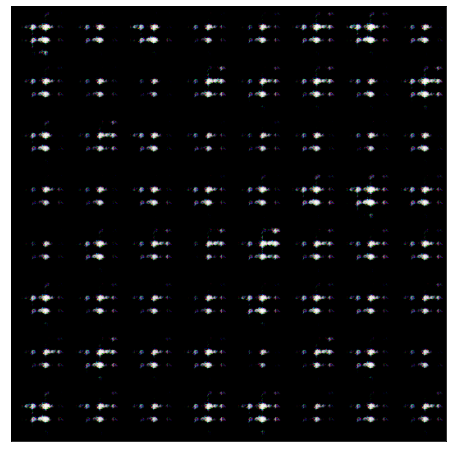

Epoch [101/300], loss_g: 8.0270, loss_d: 0.0279, acc_real: 0.9859, acc_fake: 0.0107
Epoch [102/300], loss_g: 8.4969, loss_d: 0.0763, acc_real: 0.9907, acc_fake: 0.0544
Epoch [103/300], loss_g: 8.0007, loss_d: 0.0562, acc_real: 0.9954, acc_fake: 0.0392
Epoch [104/300], loss_g: 9.6851, loss_d: 0.0596, acc_real: 0.9652, acc_fake: 0.0010
Epoch [105/300], loss_g: 12.2010, loss_d: 0.0226, acc_real: 0.9838, acc_fake: 0.0025
Epoch [106/300], loss_g: 7.4989, loss_d: 0.0521, acc_real: 0.9946, acc_fake: 0.0347
Epoch [107/300], loss_g: 8.4791, loss_d: 0.0417, acc_real: 0.9730, acc_fake: 0.0041
Epoch [108/300], loss_g: 10.6319, loss_d: 0.0177, acc_real: 0.9876, acc_fake: 0.0027
Epoch [109/300], loss_g: 8.4577, loss_d: 0.1187, acc_real: 0.9874, acc_fake: 0.0702


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [110/300], loss_g: 9.4865, loss_d: 0.1195, acc_real: 0.9754, acc_fake: 0.0648


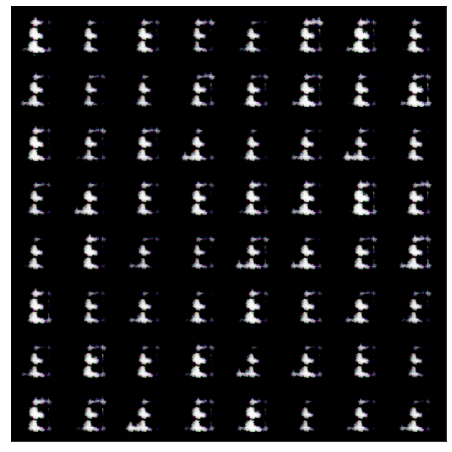

Epoch [111/300], loss_g: 11.4657, loss_d: 0.1400, acc_real: 0.9443, acc_fake: 0.0144
Epoch [112/300], loss_g: 8.9713, loss_d: 0.2291, acc_real: 0.9007, acc_fake: 0.0040
Epoch [113/300], loss_g: 8.4091, loss_d: 0.0637, acc_real: 0.9543, acc_fake: 0.0040
Epoch [114/300], loss_g: 9.6132, loss_d: 0.0591, acc_real: 0.9536, acc_fake: 0.0038
Epoch [115/300], loss_g: 9.0792, loss_d: 0.0424, acc_real: 0.9748, acc_fake: 0.0098
Epoch [116/300], loss_g: 7.7230, loss_d: 0.0226, acc_real: 0.9975, acc_fake: 0.0181
Epoch [117/300], loss_g: 8.2799, loss_d: 0.0172, acc_real: 0.9889, acc_fake: 0.0037
Epoch [118/300], loss_g: 7.2785, loss_d: 0.0128, acc_real: 0.9971, acc_fake: 0.0095
Epoch [119/300], loss_g: 7.7977, loss_d: 0.0716, acc_real: 0.9789, acc_fake: 0.0299


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [120/300], loss_g: 8.2420, loss_d: 0.0873, acc_real: 0.9671, acc_fake: 0.0190


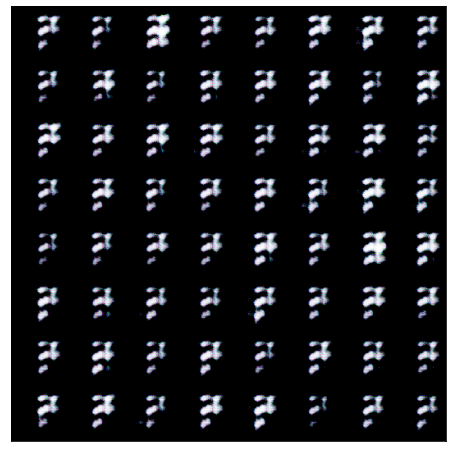

Epoch [121/300], loss_g: 9.0303, loss_d: 0.0475, acc_real: 0.9805, acc_fake: 0.0208
Epoch [122/300], loss_g: 11.0637, loss_d: 0.0844, acc_real: 0.9898, acc_fake: 0.0328
Epoch [123/300], loss_g: 10.1317, loss_d: 0.1064, acc_real: 0.9819, acc_fake: 0.0445
Epoch [124/300], loss_g: 9.6137, loss_d: 0.0304, acc_real: 0.9813, acc_fake: 0.0088
Epoch [125/300], loss_g: 8.6945, loss_d: 0.0595, acc_real: 0.9791, acc_fake: 0.0262
Epoch [126/300], loss_g: 7.8862, loss_d: 0.0520, acc_real: 0.9947, acc_fake: 0.0352
Epoch [127/300], loss_g: 8.4078, loss_d: 0.1133, acc_real: 0.9902, acc_fake: 0.0647
Epoch [128/300], loss_g: 10.6899, loss_d: 0.0881, acc_real: 0.9790, acc_fake: 0.0362
Epoch [129/300], loss_g: 13.4842, loss_d: 0.0267, acc_real: 0.9886, acc_fake: 0.0116


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [130/300], loss_g: 13.2994, loss_d: 0.0426, acc_real: 0.9834, acc_fake: 0.0096


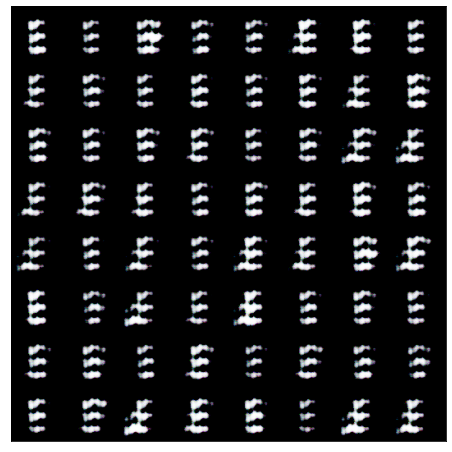

Epoch [131/300], loss_g: 8.5604, loss_d: 0.0424, acc_real: 0.9988, acc_fake: 0.0292
Epoch [132/300], loss_g: 11.8185, loss_d: 0.0723, acc_real: 0.9526, acc_fake: 0.0015
Epoch [133/300], loss_g: 10.2935, loss_d: 0.0264, acc_real: 0.9862, acc_fake: 0.0074
Epoch [134/300], loss_g: 6.8398, loss_d: 0.0500, acc_real: 0.9965, acc_fake: 0.0383
Epoch [135/300], loss_g: 9.3872, loss_d: 0.0208, acc_real: 0.9826, acc_fake: 0.0014
Epoch [136/300], loss_g: 11.1494, loss_d: 0.0261, acc_real: 0.9818, acc_fake: 0.0023
Epoch [137/300], loss_g: 8.2456, loss_d: 0.0400, acc_real: 0.9951, acc_fake: 0.0286
Epoch [138/300], loss_g: 7.8408, loss_d: 0.0896, acc_real: 0.9828, acc_fake: 0.0445
Epoch [139/300], loss_g: 6.8497, loss_d: 0.0628, acc_real: 0.9984, acc_fake: 0.0442


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [140/300], loss_g: 8.1808, loss_d: 0.0189, acc_real: 0.9890, acc_fake: 0.0055


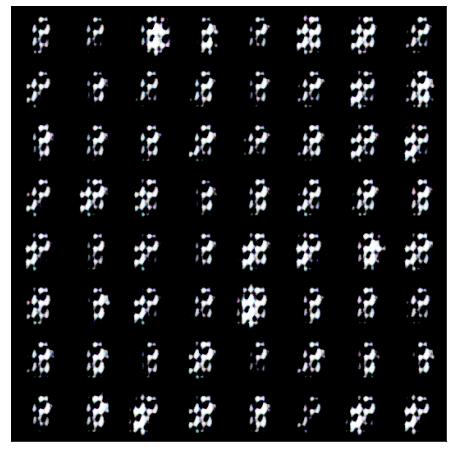

Epoch [141/300], loss_g: 8.7933, loss_d: 0.0345, acc_real: 0.9827, acc_fake: 0.0125
Epoch [142/300], loss_g: 9.2924, loss_d: 0.0515, acc_real: 0.9732, acc_fake: 0.0166
Epoch [143/300], loss_g: 9.6100, loss_d: 0.0396, acc_real: 0.9729, acc_fake: 0.0052
Epoch [144/300], loss_g: 11.2825, loss_d: 0.0045, acc_real: 0.9970, acc_fake: 0.0014
Epoch [145/300], loss_g: 9.1133, loss_d: 0.0982, acc_real: 0.9995, acc_fake: 0.0744
Epoch [146/300], loss_g: 10.6048, loss_d: 0.1987, acc_real: 0.9969, acc_fake: 0.1117
Epoch [147/300], loss_g: 11.3573, loss_d: 0.2057, acc_real: 0.9993, acc_fake: 0.1263
Epoch [148/300], loss_g: 6.6799, loss_d: 0.1050, acc_real: 0.9999, acc_fake: 0.0751
Epoch [149/300], loss_g: 14.5166, loss_d: 0.1091, acc_real: 0.9395, acc_fake: 0.0000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [150/300], loss_g: 7.6392, loss_d: 0.0160, acc_real: 0.9995, acc_fake: 0.0133


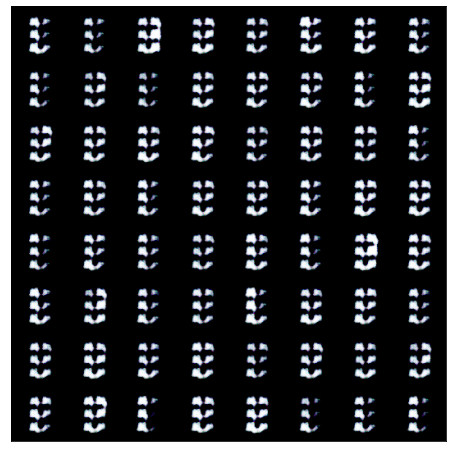

Epoch [151/300], loss_g: 10.4662, loss_d: 0.0067, acc_real: 0.9972, acc_fake: 0.0037
Epoch [152/300], loss_g: 8.1021, loss_d: 0.0629, acc_real: 0.9723, acc_fake: 0.0032
Epoch [153/300], loss_g: 9.2380, loss_d: 0.0288, acc_real: 0.9808, acc_fake: 0.0037
Epoch [154/300], loss_g: 7.2814, loss_d: 0.0618, acc_real: 0.9899, acc_fake: 0.0393
Epoch [155/300], loss_g: 8.2492, loss_d: 0.0411, acc_real: 0.9694, acc_fake: 0.0019
Epoch [156/300], loss_g: 11.3020, loss_d: 0.0160, acc_real: 0.9916, acc_fake: 0.0051
Epoch [157/300], loss_g: 8.3959, loss_d: 0.0445, acc_real: 0.9812, acc_fake: 0.0086
Epoch [158/300], loss_g: 11.3521, loss_d: 0.0044, acc_real: 0.9980, acc_fake: 0.0023
Epoch [159/300], loss_g: 7.1955, loss_d: 0.0112, acc_real: 0.9969, acc_fake: 0.0077


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [160/300], loss_g: 10.8265, loss_d: 0.0319, acc_real: 0.9948, acc_fake: 0.0193


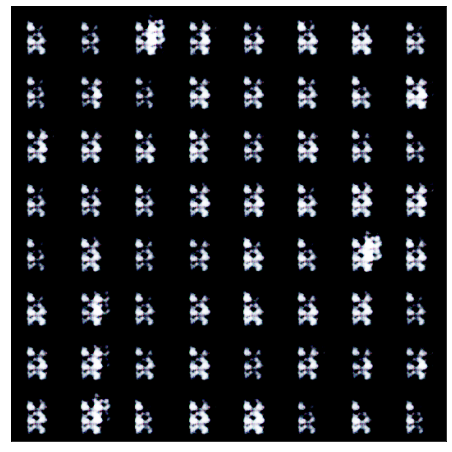

Epoch [161/300], loss_g: 9.5612, loss_d: 0.0354, acc_real: 0.9997, acc_fake: 0.0247
Epoch [162/300], loss_g: 8.8388, loss_d: 0.0108, acc_real: 0.9950, acc_fake: 0.0053
Epoch [163/300], loss_g: 9.8246, loss_d: 0.0547, acc_real: 0.9906, acc_fake: 0.0279
Epoch [164/300], loss_g: 8.5568, loss_d: 0.0415, acc_real: 0.9958, acc_fake: 0.0258
Epoch [165/300], loss_g: 9.5801, loss_d: 0.0250, acc_real: 0.9956, acc_fake: 0.0168
Epoch [166/300], loss_g: 8.8580, loss_d: 0.0410, acc_real: 0.9990, acc_fake: 0.0281
Epoch [167/300], loss_g: 9.6213, loss_d: 0.0397, acc_real: 0.9953, acc_fake: 0.0242
Epoch [168/300], loss_g: 8.9876, loss_d: 0.0389, acc_real: 0.9934, acc_fake: 0.0226
Epoch [169/300], loss_g: 8.3301, loss_d: 0.0206, acc_real: 0.9985, acc_fake: 0.0172


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [170/300], loss_g: 9.6929, loss_d: 0.0394, acc_real: 0.9850, acc_fake: 0.0021


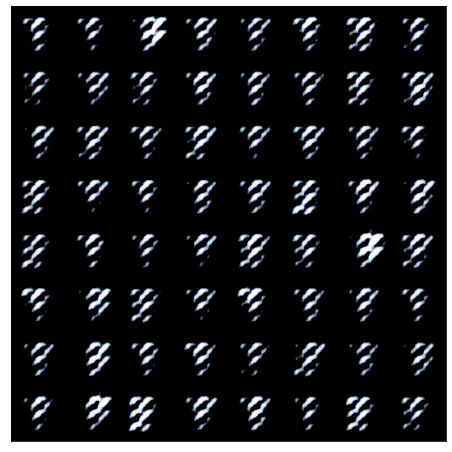

Epoch [171/300], loss_g: 10.2521, loss_d: 0.0094, acc_real: 0.9994, acc_fake: 0.0083
Epoch [172/300], loss_g: 8.4724, loss_d: 0.0161, acc_real: 0.9970, acc_fake: 0.0107
Epoch [173/300], loss_g: 8.1739, loss_d: 0.0315, acc_real: 0.9921, acc_fake: 0.0204
Epoch [174/300], loss_g: 8.9771, loss_d: 0.0148, acc_real: 0.9883, acc_fake: 0.0018
Epoch [175/300], loss_g: 8.3403, loss_d: 0.0531, acc_real: 0.9885, acc_fake: 0.0292
Epoch [176/300], loss_g: 10.2501, loss_d: 0.0316, acc_real: 0.9925, acc_fake: 0.0200
Epoch [177/300], loss_g: 8.9298, loss_d: 0.0656, acc_real: 0.9991, acc_fake: 0.0408
Epoch [178/300], loss_g: 9.1869, loss_d: 0.0209, acc_real: 0.9846, acc_fake: 0.0033
Epoch [179/300], loss_g: 9.3016, loss_d: 0.0620, acc_real: 0.9707, acc_fake: 0.0034


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [180/300], loss_g: 8.0263, loss_d: 0.0260, acc_real: 0.9849, acc_fake: 0.0076


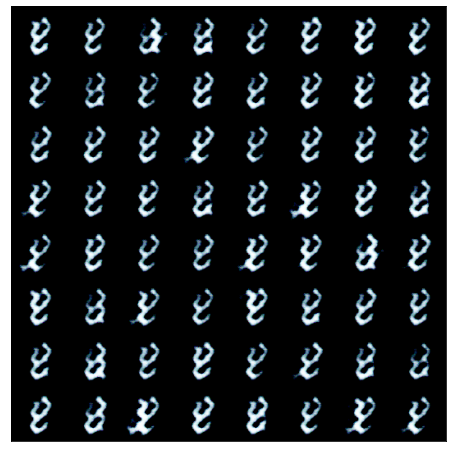

Epoch [181/300], loss_g: 7.2104, loss_d: 0.0413, acc_real: 0.9724, acc_fake: 0.0052
Epoch [182/300], loss_g: 8.6776, loss_d: 0.0420, acc_real: 0.9839, acc_fake: 0.0185
Epoch [183/300], loss_g: 7.7287, loss_d: 0.0499, acc_real: 0.9894, acc_fake: 0.0257
Epoch [184/300], loss_g: 7.3971, loss_d: 0.0435, acc_real: 0.9904, acc_fake: 0.0265
Epoch [185/300], loss_g: 7.3086, loss_d: 0.0284, acc_real: 0.9877, acc_fake: 0.0059
Epoch [186/300], loss_g: 9.1631, loss_d: 0.0190, acc_real: 0.9842, acc_fake: 0.0020
Epoch [187/300], loss_g: 9.2264, loss_d: 0.0597, acc_real: 0.9803, acc_fake: 0.0064
Epoch [188/300], loss_g: 10.6972, loss_d: 0.0094, acc_real: 0.9943, acc_fake: 0.0033
Epoch [189/300], loss_g: 8.9009, loss_d: 0.0254, acc_real: 0.9984, acc_fake: 0.0203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [190/300], loss_g: 10.4953, loss_d: 0.0073, acc_real: 0.9957, acc_fake: 0.0025


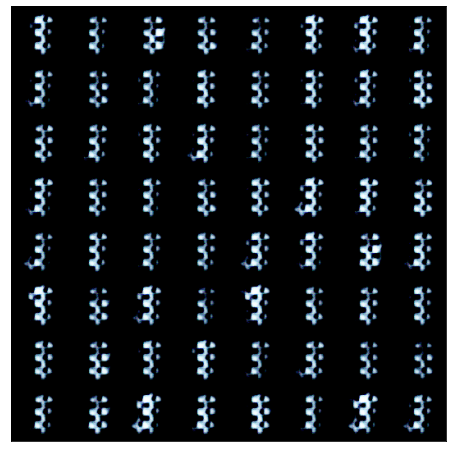

Epoch [191/300], loss_g: 8.7036, loss_d: 0.0124, acc_real: 0.9995, acc_fake: 0.0112
Epoch [192/300], loss_g: 9.4737, loss_d: 0.0134, acc_real: 0.9959, acc_fake: 0.0079
Epoch [193/300], loss_g: 9.2566, loss_d: 0.0188, acc_real: 0.9918, acc_fake: 0.0072
Epoch [194/300], loss_g: 10.4878, loss_d: 0.0023, acc_real: 0.9982, acc_fake: 0.0004
Epoch [195/300], loss_g: 8.7717, loss_d: 0.0142, acc_real: 0.9999, acc_fake: 0.0118
Epoch [196/300], loss_g: 10.0763, loss_d: 0.0108, acc_real: 0.9927, acc_fake: 0.0015
Epoch [197/300], loss_g: 9.3178, loss_d: 0.0292, acc_real: 0.9994, acc_fake: 0.0239
Epoch [198/300], loss_g: 9.3256, loss_d: 0.0666, acc_real: 0.9979, acc_fake: 0.0386
Epoch [199/300], loss_g: 11.7218, loss_d: 0.0036, acc_real: 0.9967, acc_fake: 0.0002


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [200/300], loss_g: 8.8390, loss_d: 0.0267, acc_real: 0.9997, acc_fake: 0.0200


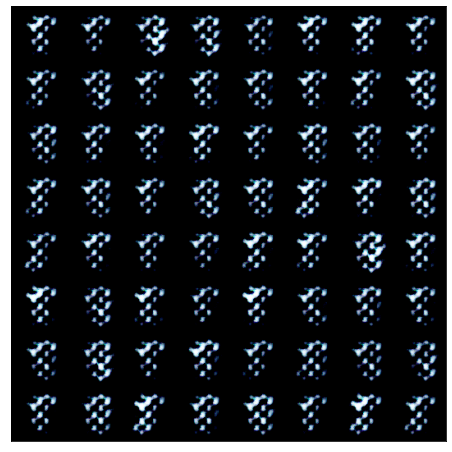

Epoch [201/300], loss_g: 11.0443, loss_d: 0.0516, acc_real: 0.9782, acc_fake: 0.0035
Epoch [202/300], loss_g: 9.2767, loss_d: 0.0242, acc_real: 0.9906, acc_fake: 0.0130
Epoch [203/300], loss_g: 8.6192, loss_d: 0.0065, acc_real: 0.9988, acc_fake: 0.0052
Epoch [204/300], loss_g: 10.3817, loss_d: 0.0054, acc_real: 0.9975, acc_fake: 0.0027
Epoch [205/300], loss_g: 9.1946, loss_d: 0.0107, acc_real: 0.9978, acc_fake: 0.0076
Epoch [206/300], loss_g: 9.2967, loss_d: 0.0059, acc_real: 0.9959, acc_fake: 0.0014
Epoch [207/300], loss_g: 11.6332, loss_d: 0.0075, acc_real: 0.9963, acc_fake: 0.0034
Epoch [208/300], loss_g: 9.3075, loss_d: 0.0095, acc_real: 0.9991, acc_fake: 0.0080
Epoch [209/300], loss_g: 9.7427, loss_d: 0.0122, acc_real: 0.9924, acc_fake: 0.0041


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [210/300], loss_g: 9.5491, loss_d: 0.0313, acc_real: 0.9876, acc_fake: 0.0130


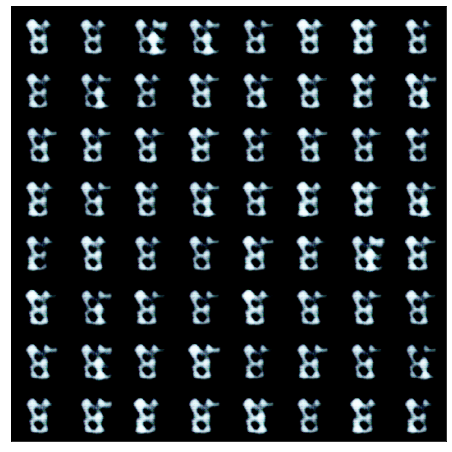

Epoch [211/300], loss_g: 10.9896, loss_d: 0.0150, acc_real: 0.9889, acc_fake: 0.0026
Epoch [212/300], loss_g: 8.4413, loss_d: 0.0228, acc_real: 0.9969, acc_fake: 0.0177
Epoch [213/300], loss_g: 8.5331, loss_d: 0.0401, acc_real: 0.9894, acc_fake: 0.0197
Epoch [214/300], loss_g: 9.0303, loss_d: 0.0248, acc_real: 0.9953, acc_fake: 0.0183
Epoch [215/300], loss_g: 9.9447, loss_d: 0.0278, acc_real: 0.9866, acc_fake: 0.0096
Epoch [216/300], loss_g: 9.4463, loss_d: 0.0521, acc_real: 0.9739, acc_fake: 0.0047
Epoch [217/300], loss_g: 9.7240, loss_d: 0.0457, acc_real: 0.9754, acc_fake: 0.0062
Epoch [218/300], loss_g: 9.9757, loss_d: 0.1385, acc_real: 0.9695, acc_fake: 0.0414
Epoch [219/300], loss_g: 5.9084, loss_d: 0.0118, acc_real: 0.9986, acc_fake: 0.0101


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [220/300], loss_g: 11.7021, loss_d: 0.0329, acc_real: 0.9867, acc_fake: 0.0000


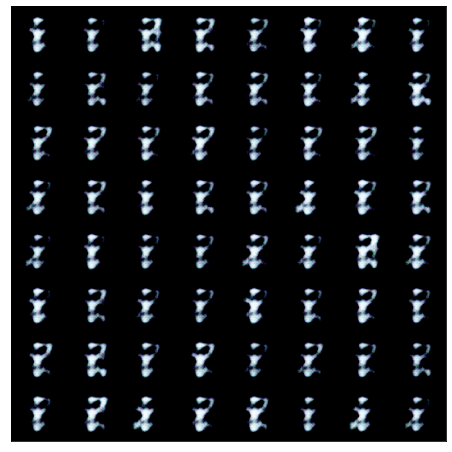

Epoch [221/300], loss_g: 18.4692, loss_d: 0.0117, acc_real: 0.9911, acc_fake: 0.0000
Epoch [222/300], loss_g: 9.2676, loss_d: 0.0287, acc_real: 0.9877, acc_fake: 0.0005
Epoch [223/300], loss_g: 11.8443, loss_d: 0.3131, acc_real: 0.8794, acc_fake: 0.0000
Epoch [224/300], loss_g: 14.2889, loss_d: 0.2642, acc_real: 0.8918, acc_fake: 0.0000
Epoch [225/300], loss_g: 8.8057, loss_d: 0.1217, acc_real: 0.9996, acc_fake: 0.0859
Epoch [226/300], loss_g: 8.3881, loss_d: 0.0167, acc_real: 0.9902, acc_fake: 0.0019
Epoch [227/300], loss_g: 10.8714, loss_d: 0.0040, acc_real: 0.9979, acc_fake: 0.0019
Epoch [228/300], loss_g: 7.3838, loss_d: 0.0723, acc_real: 0.9899, acc_fake: 0.0351
Epoch [229/300], loss_g: 8.9601, loss_d: 0.0275, acc_real: 0.9849, acc_fake: 0.0077


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [230/300], loss_g: 8.6987, loss_d: 0.0357, acc_real: 0.9863, acc_fake: 0.0124


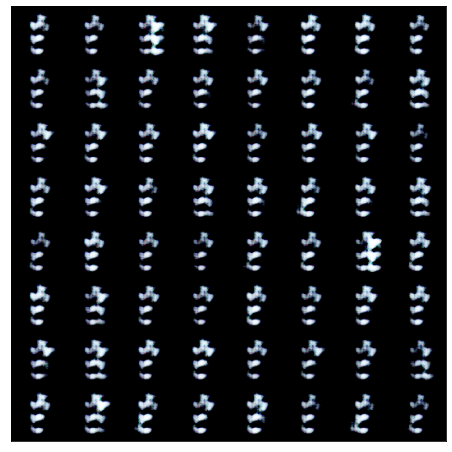

Epoch [231/300], loss_g: 8.3174, loss_d: 0.0352, acc_real: 0.9968, acc_fake: 0.0272
Epoch [232/300], loss_g: 10.4600, loss_d: 0.0233, acc_real: 0.9897, acc_fake: 0.0085
Epoch [233/300], loss_g: 9.4244, loss_d: 0.0138, acc_real: 0.9931, acc_fake: 0.0063
Epoch [234/300], loss_g: 10.7353, loss_d: 0.0361, acc_real: 0.9948, acc_fake: 0.0214
Epoch [235/300], loss_g: 9.2989, loss_d: 0.0426, acc_real: 0.9939, acc_fake: 0.0212
Epoch [236/300], loss_g: 11.5620, loss_d: 0.0566, acc_real: 0.9723, acc_fake: 0.0044
Epoch [237/300], loss_g: 10.5712, loss_d: 0.0599, acc_real: 0.9996, acc_fake: 0.0431
Epoch [238/300], loss_g: 11.8932, loss_d: 0.0153, acc_real: 0.9873, acc_fake: 0.0009
Epoch [239/300], loss_g: 10.0229, loss_d: 0.0162, acc_real: 0.9989, acc_fake: 0.0122


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [240/300], loss_g: 12.0838, loss_d: 0.0067, acc_real: 0.9948, acc_fake: 0.0008


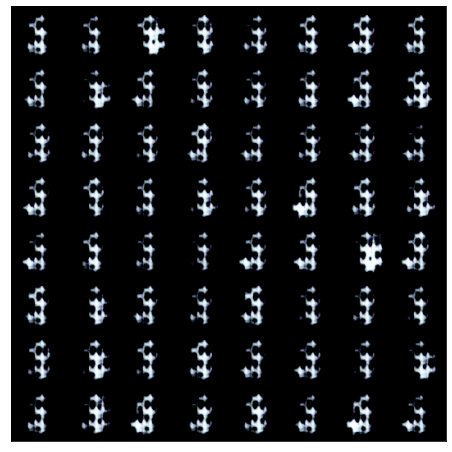

Epoch [241/300], loss_g: 8.8057, loss_d: 0.0069, acc_real: 0.9991, acc_fake: 0.0058
Epoch [242/300], loss_g: 8.9656, loss_d: 0.0251, acc_real: 0.9829, acc_fake: 0.0035
Epoch [243/300], loss_g: 10.0675, loss_d: 0.0471, acc_real: 0.9851, acc_fake: 0.0044
Epoch [244/300], loss_g: 9.3544, loss_d: 0.0184, acc_real: 0.9904, acc_fake: 0.0071
Epoch [245/300], loss_g: 9.1400, loss_d: 0.0075, acc_real: 0.9975, acc_fake: 0.0047
Epoch [246/300], loss_g: 9.6123, loss_d: 0.0280, acc_real: 0.9962, acc_fake: 0.0182
Epoch [247/300], loss_g: 7.5717, loss_d: 0.0203, acc_real: 0.9941, acc_fake: 0.0109
Epoch [248/300], loss_g: 11.7435, loss_d: 0.0059, acc_real: 0.9958, acc_fake: 0.0015
Epoch [249/300], loss_g: 8.8658, loss_d: 0.0072, acc_real: 0.9996, acc_fake: 0.0064


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [250/300], loss_g: 11.8081, loss_d: 0.0048, acc_real: 0.9974, acc_fake: 0.0020


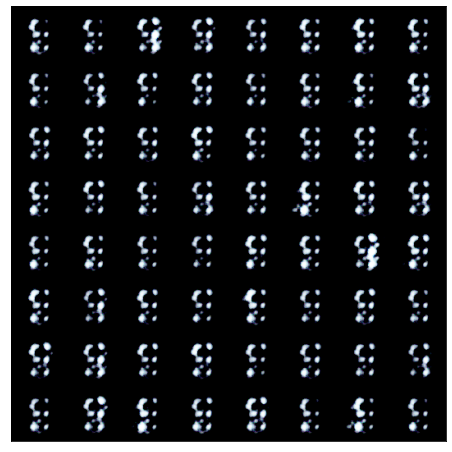

Epoch [251/300], loss_g: 7.7386, loss_d: 0.0094, acc_real: 0.9963, acc_fake: 0.0051
Epoch [252/300], loss_g: 10.7438, loss_d: 0.0294, acc_real: 0.9813, acc_fake: 0.0025
Epoch [253/300], loss_g: 9.5142, loss_d: 0.0348, acc_real: 0.9982, acc_fake: 0.0281
Epoch [254/300], loss_g: 8.6512, loss_d: 0.0030, acc_real: 0.9979, acc_fake: 0.0008
Epoch [255/300], loss_g: 10.3086, loss_d: 0.0081, acc_real: 0.9964, acc_fake: 0.0042
Epoch [256/300], loss_g: 9.0421, loss_d: 0.0152, acc_real: 0.9978, acc_fake: 0.0122
Epoch [257/300], loss_g: 8.1580, loss_d: 0.0131, acc_real: 0.9968, acc_fake: 0.0094
Epoch [258/300], loss_g: 10.1808, loss_d: 0.0342, acc_real: 0.9811, acc_fake: 0.0080
Epoch [259/300], loss_g: 9.8013, loss_d: 0.0328, acc_real: 0.9857, acc_fake: 0.0127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [260/300], loss_g: 7.7990, loss_d: 0.0408, acc_real: 0.9988, acc_fake: 0.0354


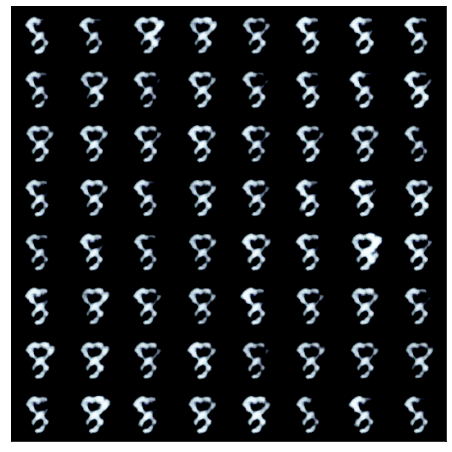

Epoch [261/300], loss_g: 7.2254, loss_d: 0.0208, acc_real: 0.9881, acc_fake: 0.0060
Epoch [262/300], loss_g: 10.3643, loss_d: 0.0100, acc_real: 0.9922, acc_fake: 0.0011
Epoch [263/300], loss_g: 8.1999, loss_d: 0.0255, acc_real: 0.9999, acc_fake: 0.0210
Epoch [264/300], loss_g: 9.9800, loss_d: 0.0033, acc_real: 0.9993, acc_fake: 0.0025
Epoch [265/300], loss_g: 8.8258, loss_d: 0.0174, acc_real: 0.9989, acc_fake: 0.0148
Epoch [266/300], loss_g: 7.5375, loss_d: 0.0163, acc_real: 0.9975, acc_fake: 0.0128
Epoch [267/300], loss_g: 11.5430, loss_d: 0.0192, acc_real: 0.9989, acc_fake: 0.0097
Epoch [268/300], loss_g: 9.6453, loss_d: 0.0058, acc_real: 0.9986, acc_fake: 0.0042
Epoch [269/300], loss_g: 12.6362, loss_d: 0.0064, acc_real: 0.9957, acc_fake: 0.0013


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [270/300], loss_g: 8.7194, loss_d: 0.0067, acc_real: 0.9991, acc_fake: 0.0053


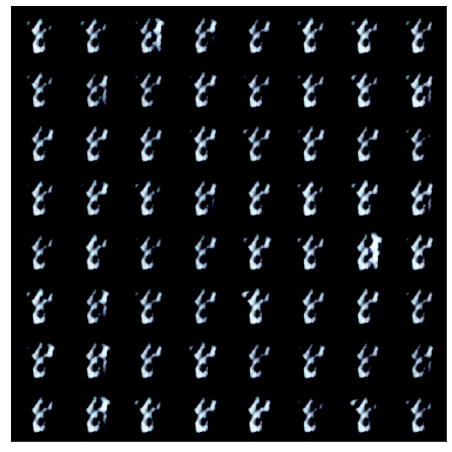

Epoch [271/300], loss_g: 12.9022, loss_d: 0.0016, acc_real: 0.9988, acc_fake: 0.0004
Epoch [272/300], loss_g: 8.1969, loss_d: 0.0070, acc_real: 0.9981, acc_fake: 0.0048
Epoch [273/300], loss_g: 10.2787, loss_d: 0.0048, acc_real: 0.9966, acc_fake: 0.0013
Epoch [274/300], loss_g: 8.3407, loss_d: 0.0560, acc_real: 0.9840, acc_fake: 0.0262
Epoch [275/300], loss_g: 8.9141, loss_d: 0.0156, acc_real: 0.9920, acc_fake: 0.0062
Epoch [276/300], loss_g: 11.7852, loss_d: 0.0309, acc_real: 0.9793, acc_fake: 0.0023
Epoch [277/300], loss_g: 9.5715, loss_d: 0.0420, acc_real: 0.9908, acc_fake: 0.0241
Epoch [278/300], loss_g: 10.6370, loss_d: 0.0652, acc_real: 0.9710, acc_fake: 0.0017
Epoch [279/300], loss_g: 10.1195, loss_d: 0.0485, acc_real: 0.9793, acc_fake: 0.0046


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [280/300], loss_g: 9.9750, loss_d: 0.0284, acc_real: 0.9864, acc_fake: 0.0044


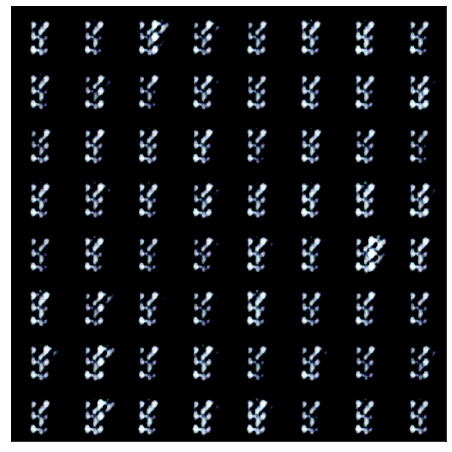

Epoch [281/300], loss_g: 10.1010, loss_d: 0.0375, acc_real: 0.9850, acc_fake: 0.0039
Epoch [282/300], loss_g: 12.4320, loss_d: 0.0246, acc_real: 0.9853, acc_fake: 0.0041
Epoch [283/300], loss_g: 11.2918, loss_d: 0.0064, acc_real: 0.9996, acc_fake: 0.0058
Epoch [284/300], loss_g: 12.3665, loss_d: 0.0114, acc_real: 0.9963, acc_fake: 0.0058
Epoch [285/300], loss_g: 10.1496, loss_d: 0.0360, acc_real: 0.9985, acc_fake: 0.0151
Epoch [286/300], loss_g: 12.1048, loss_d: 0.0081, acc_real: 0.9937, acc_fake: 0.0004
Epoch [287/300], loss_g: 10.3541, loss_d: 0.0231, acc_real: 0.9960, acc_fake: 0.0151
Epoch [288/300], loss_g: 10.1868, loss_d: 0.0126, acc_real: 0.9925, acc_fake: 0.0032
Epoch [289/300], loss_g: 11.1300, loss_d: 0.0197, acc_real: 0.9899, acc_fake: 0.0046


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [290/300], loss_g: 11.2392, loss_d: 0.0055, acc_real: 0.9962, acc_fake: 0.0014


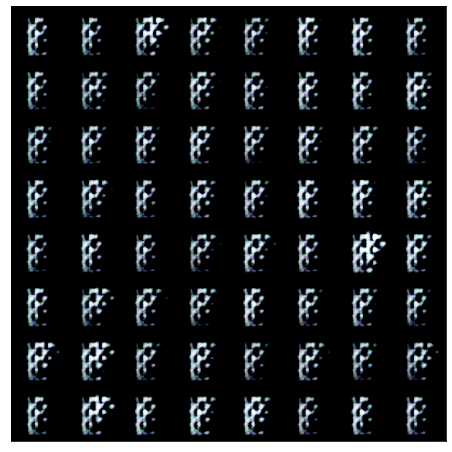

Epoch [291/300], loss_g: 9.4083, loss_d: 0.0100, acc_real: 0.9995, acc_fake: 0.0089
Epoch [292/300], loss_g: 11.3838, loss_d: 0.0035, acc_real: 0.9973, acc_fake: 0.0006
Epoch [293/300], loss_g: 8.5693, loss_d: 0.0080, acc_real: 0.9990, acc_fake: 0.0067
Epoch [294/300], loss_g: 13.1084, loss_d: 0.0379, acc_real: 0.9825, acc_fake: 0.0001
Epoch [295/300], loss_g: 10.7898, loss_d: 0.0038, acc_real: 0.9969, acc_fake: 0.0003
Epoch [296/300], loss_g: 9.2268, loss_d: 0.0172, acc_real: 0.9998, acc_fake: 0.0151
Epoch [297/300], loss_g: 10.9351, loss_d: 0.0024, acc_real: 0.9984, acc_fake: 0.0008
Epoch [298/300], loss_g: 8.6656, loss_d: 0.0028, acc_real: 0.9997, acc_fake: 0.0024
Epoch [299/300], loss_g: 10.4756, loss_d: 0.0067, acc_real: 0.9977, acc_fake: 0.0041


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [300/300], loss_g: 9.7320, loss_d: 0.0082, acc_real: 0.9988, acc_fake: 0.0066


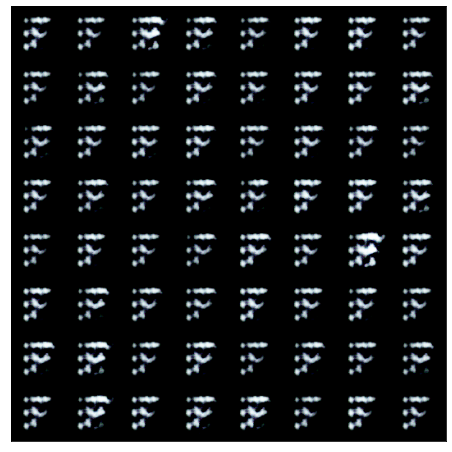

In [20]:
#--- Definimos la rata de aprendizaje y el número de épocas.
n_epoch = 300

g_losses, d_losses, accs_real, accs_fake = fit(n_epoch)

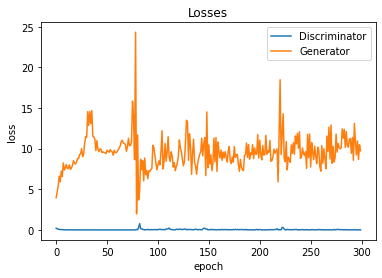

In [21]:
#-- Graficamos Loss y Accuracy
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

plt.subplot(1,2,2)
plt.plot(accs_real, '-')
plt.plot(accs_fake, '-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Real acc', 'Fake acc'])
plt.title('Accuracys')
plt.show()

In [23]:
#--- Guardamos el nuevo modelo
torch.save(generator,open('./GAN_MNIST.pt','wb'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


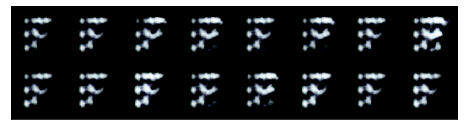

In [24]:
#--- Cargamos y probamos nuestra GAN
model = torch.load('./GAN_MNIST.pt')
model.eval()
fixed_latent = torch.randn(16, latent_size, 1, 1, device=device)
fake_images = model(fixed_latent.cuda())

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
plt.show()

In [ ]:
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')